# The finite element method <a class="tocSkip">

## Lecture 3: implementing a FEM solver in higher dimensions (Firedrake) <a class="tocSkip">

In [2]:
%precision 6
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
from pprint import pprint

# some default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# Higher dimensions

## Triangular meshes
As we have seen in the previous lecture a natural basis for the functionspaces used in the FEM in 1D is obtained by dividing the domain interval into smaller sub-intervals, the elements or cells. The function space is then formed by piecewise constant, linear, quadratic, etc. functions that are either continuous or discontinuous between subsequent elements. For a piecewise linear function we need the value in the two end points of each element, the nodes. For continuous functions each node is shared between two adjacent elements.

We can do something very similar in two dimensions: to uniquely determine a linear function within an element, we need its value in three points. A natural candidate for the geometric shape of the elements in 2D is therefore the triangle, with the value of each function stored in the three vertices of the triangle. By dividing a two-dimensional domain into a number of triangles, a so called triangulation, we can then choose our function space to be all piecewise linear functions on that triangulation.

Here we start seeing some of the bigger differences between Finite Difference Methods (FDM), which usually require the degrees of freedom to be stored on a rectangular mesh, that is structured in nature; The connections between the nodes form a regular pattern, with connections between the nodes in the previous and subsequent rows and columns. This is unlike unstructured, triangular meshes where there exists no pattern in the connection between the nodes. This is actually one of big advantages of the FEM: with unstructured, triangular meshes it is a lot easier to accurately describe a complex geometry, and also to smoothly vary the resolution.

<img src="figures/orkney-mesh.jpg" style="width: 800px">

To generate a triangular mesh in a complex geometry we require a piece of software called a mesh generator. Here we will be using [Gmsh](http://gmsh.info/), which is available freely. To deal with the additional challenges associated with geophysical domains (oceans!), such as coastlines and bathymetries from different sources and different coordinate systems, we point at [qmesh](http://qmesh.org/), developed at Imperial College (see also [this paper](https://doi.org/10.1016/j.renene.2017.09.058) for more information).

## From a mesh to basis functions
In 1D we could form a basis for the space of piecewise linear continuous functions, from "hat" (or "tent") functions that are 1 in a single node, and are 0 in all others, e.g.:
<img src="figures/hat-function-1d.png" width="400:pix">

In two dimension we do exactly the same. This is what it looks like:

<img src="figures/hat-function-2d.svg" width="400:pix">

<sup>**[source](http://brickisland.net/cs177/?p=309)**</sup>
As you can see the basis function $\phi_i$ is 1 in the node $i$ and linearly decreases to 0 in the adjacent triangles. Anywhere else $\phi_i$ is 0. Just like in 1D, we can write any piecewise linear function as a linear combination of such basis functions:

$$f_h(x) = \sum_{i=0}^N \alpha_i \phi_i(x). $$

It is also possible to allow for higher degree polynomials. For piecewise *quadratic* polynomials, we need the function value in six points in each triangle. A common choice is to use the same three nodes in the vertices of the triangle, and three additional nodes in the middle of each edge.

We can also choose to allow polynomials that are *discontinous* between adjacent triangles. The "hat" basis functions displayed above are continuous, and thus the linear combination of these are continuous as well. By choosing baiss functions that are nonzero in a single triangle only, i.e. it takes the value of one in one vertex *inside* the triangle, but jumps to zero immediately outside the triangle, we can form discontinuous functions as well. The choice between continuous and discontinuous basis functions leads to the so called Continuous Galerkin (CG) and Discontinuous Galerkin (DG) methods

<img src="https://mathstats.uncg.edu/applied/wp-content/uploads/sites/2/2018/01/DG_CG_edit.jpg">

<sup>**[source](https://mathstats.uncg.edu/applied/wp-content/uploads/sites/2/2018/01/DG_CG_edit.jpg)**</sup>

Finally, we should note that we do not *have to* use triangular meshes for the FEM. Quadrilateral meshes are another possibility where we can for instance choose piecewise *bilinear* basis functions.

## Connectivity in 2D

The following image presents a schematic of an unstructured mesh data structure, or connectivity, in the 2D case and assuming that:


1. our **elements** are triangular and defined by the locations of three vertices and the edges joining them


2. we have three **nodes** (degrees of freedom) per element


3. and that these are located at the **vertices** of the elements 

As stated above, other more complex choices are possible with each of the three above assumptions. For example, we could have quadrilateral elements, with nine nodes per elements, located at the four corners, the four edge midpoints, and with one at the centre of the element.

Here we assume a piecewise linear continous functionspace, where the function will be interpolated between the values stored at the nodes which here coincide with the vertices. The fact that the nodal value is thus shared between all the adjacent triangles guarantees continuity.

<img src="figures/connectivity_2d.svg" style="width: 400px">


- Blue are the *element numbers*


- Red are the *local node numbers*


- Black are the *global node numbers*


The connectivity matrix for the case above is

\begin{pmatrix}
    6 & 1 & 3 & 5 & 5 \\
    4 & 4 & 1 & 1 & 6 \\
    1 & 2 & 2 & 3 & 1
\end{pmatrix}

the column being the element, the row the local node number, and the entry of the matrix then being the global node number.

The size of the connectivity matrix is again: 

$$\text{the number of local nodes per element}\;\;\times\;\;\text{the number of elements}
\;\;\;\ = \;\; 3\;\times\;5.$$

## Local assembly, the reference element and implementing FEM in 2D

An advantage of the local assembly approach we described and implemented for the 1D case in the previous lecture, is that it generalises straightforwardly to higher dimensions.


- We still loop over the elements and perform integrals over the local element only.


- To do this we use the following reference element.


<img src="figures/reference_elements_2d.svg" style="width: 600px">


- We need quadrature rules over triangles, but these are easy to find.


- We need to define our basis functions over the reference element, but this isn't difficult, especially for the p/w linear option:

$$\phi_0 = 1 - \xi - \eta, \;\;\;\;\;\; \phi_1 = \xi, \;\;\;\;\;\; \phi_2 = \eta.$$


- We need to consider how derivatives transform, but this just involves the correct use of the Jacobian matrix.


- To implement Dirichlet BCs, we can again use the big spring approach as we did above for simplicity, or we can use the approach we used when we considered BVPs where we removed these degrees of freedom from our discretisation.


- For Neumann conditions we need to evaluate surface integrals - in the 2D case this involves performing 1D quadrature over the appropriate boundary edges, and in 3D surface integrals over appropriate faces.


### But should we?

We therefore have all we need to implement a FEM in 2 or 3D!

However, it would be a challenge to make this general (in terms of discretisation details and PDE problem we can apply it to) and allow us access to all the sophisticated element choices available to us with the FEM.

Therefore a common (modern) approach is to make use of libraries to do the majority of the work for us. 

As we shall see below, through a high-level approach including the appropriate use of [*domain specific languages*](https://en.wikipedia.org/wiki/Domain-specific_language), we are able to develop highly sophisticated solvers for very complicated problems in only a few lines of Python.  

There are numerous advantages to this sort of approach.

It is highly advantageous that we know how to code up these things ourselves (as I said earlier in the course I do believe it's the case that you only truly understand a numerical algorithm after you have had a go at implementing (and debugging) it yourself). 

But that does not mean that we should in our "production codes"!!

# Mesh generation in 2D

First we briefly return to the topic of meshes and mesh generation in higher dimensions.

Here we will demonstrate some of SciPy's in-built functions. Further below we will make use of an external mesh generation package `Gmsh`.

points
[[0.  0. ]
 [0.  1.1]
 [0.9 0.1]
 [1.  1. ]
 [0.5 1.5]
 [0.2 0.6]
 [0.6 0.4]
 [0.5 1. ]]
simplices (connectivity)
[[5 1 0]
 [4 7 3]
 [1 7 4]
 [7 1 5]
 [6 7 5]
 [6 5 0]
 [2 6 0]
 [6 2 3]
 [7 6 3]]
neighbours
[[-1  5  3]
 [ 8 -1  2]
 [ 1 -1  3]
 [ 0  4  2]
 [ 3  5  8]
 [ 0  6  4]
 [ 5 -1  7]
 [-1  8  6]
 [ 7  1  4]]
vertex_neighbor_vertices (linked list)
[ 0  4  8 11 15 18 22 27 32]
[5 1 6 2 5 0 7 4 6 0 3 4 7 6 2 7 3 1 1 0 7 6 7 5 0 2 3 4 3 1 5 6]
Point  0  has neigbours  [5 1 6 2]
Point  1  has neigbours  [5 0 7 4]
Point  2  has neigbours  [6 0 3]
Point  3  has neigbours  [4 7 6 2]
Point  4  has neigbours  [7 3 1]
Point  5  has neigbours  [1 0 7 6]
Point  6  has neigbours  [7 5 0 2 3]
Point  7  has neigbours  [4 3 1 5 6]
what element is point in
5


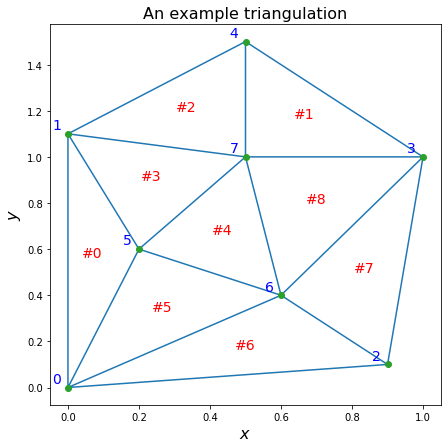

In [3]:
from scipy.spatial import Delaunay

points = np.array([[0, 0], [0, 1.1], [0.9, 0.1], [1, 1], 
                   [0.5,1.5],[0.2,0.6], [0.6,0.4], [0.5,1]])

tri = Delaunay(points, incremental=True)

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:,0], points[:,1], tri.simplices)
ax1.plot(points[:,0], points[:,1], 'o')

for j, p in enumerate(points):
    ax1.text(p[0]-0.02, p[1]+0.02, j, ha='right', color='b', fontsize=14) # label the points
for j, s in enumerate(tri.simplices):
    p = points[s].mean(axis=0)
    ax1.text(p[0], p[1], '#%d' % j, ha='center', color='r', fontsize=14) # label triangles
#ax1.set_xlim(-0.5, 1.5)
#ax1.set_ylim(-0.5, 1.5)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('An example triangulation', fontsize=16)

print('points')
print(tri.points)
print('simplices (connectivity)')
print(tri.simplices)
print('neighbours')
print(tri.neighbors)
print('vertex_neighbor_vertices (linked list)')
v0 = tri.vertex_neighbor_vertices[0]
v1 = tri.vertex_neighbor_vertices[1]
print(v0)
print(v1)
for i in range(len(v0)-1):
    print('Point ',i,' has neigbours ',v1[v0[i]:v0[i+1]])
print('what element is point in')
print(tri.find_simplex([.4,.4]))

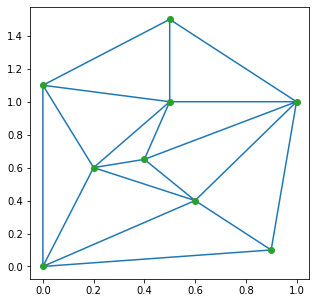

In [4]:
# this is how easily you can add a point in a triangulation
tri.add_points([[0.4,0.65]])
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(tri.points[:,0], tri.points[:,1], tri.simplices)
ax1.plot(tri.points[:,0], tri.points[:,1], 'o');

## Mesh quality and mesh improvement

A homework question asks you to implement a simple scheme to try and improve the quality of meshes such as this.

# Firedrake - solving 2D problems and a gallery of examples

[Firedrake](https://www.firedrakeproject.org/) is an example of a library that automates the application of the FEM to general PDE problems. As you have seen the extension of the FEM to multiple dimensions involves quite a few steps (mesh generation, numerical integration, complex datastructures, solving linear systems, etc.) that are non-trivial to implement. In particular for large problems with many degrees of freedom, efficient implementations are typically done in large code bases written in lower level languages such as C, C++ or Fortran. The unique feature of Firedrake, along with its cousin project [Fenics](https://fenicsproject.org/), is that it allows you to specify the actual equations you want to solve (in the weak form!) in a high level mathematical language offered via a python interface. Firedrake will take care of all the implementation details and automatically derive lower level code that is specifcally optimized for the problem you want to solve.

It is developed at Imperial College London and now the basis for many modern applications codes developed at Imperial College and a number of other institutions worldwide. Some applications include ocean modeling ([Thetis](https://thetisproject.org/)!), weather forecasting ([Gusto](https://firedrakeproject.org/gusto/)) and ice sheet modelling ([icepack](https://icepack.github.io/)).


In [5]:
import firedrake as fd

Note that we import firedrake via the shortened name `fd` which means that as usual we need to prepend `fd.` for every symbol that is offered by Firedrake. Since these symbols are used in the mathematical expressions that form the FE equations this can get a little tedious. For this reason the Firedrake documentation recommends using `from firedrake import *` instead. This however means that a lot of standard names will be overwritten by Firedrake. For instance the standard python `sin` function, which can be used on floats only, is replaced by Firedrake's version which can also be used in FE expressions. This is similar to how the `sin` function from numpy (`np.sin` when using `import numpy as np`), can act on single floats but also on an entire numpy array. Because we are using a number of different libraries in a single notebook here, we will keep the `fd.` prefix for clarity.

## Projection

To start let's check that we can use Firedrake to recreate the $L^2$ projection of a function we wrote our own assembly code to do earlier.

This is the guts of the code without comments (version with comments below!):
``` Python
mesh = fd.IntervalMesh(3, 1.0)
V = fd.FunctionSpace(mesh, "CG", 1)
x = fd.SpatialCoordinate(mesh)
f = fd.sin(2*fd.pi*x[0]) + 0.3*fd.cos(3.*2.*fd.pi*x[0]**2)
u = fd.TrialFunction(V)
v = fd.TestFunction(V)
projection_eqn = u*v*fd.dx == f*v*fd.dx
u_sol = fd.Function(V)
fd.solve(projection_eqn, u_sol)
```

Compare the length of this against the assembly code we wrote above!

The projection equation we are solving takes the form `u*v*fd.dx == f*v*fd.dx`, which is very close to the mathematical formulation

$$
  \int_I u v\,dx = \int_I f v\,dx
$$

which needs to hold for all test functions $v$. In other words, by solving this equation we demand $u=f$ in the weak sense.

We will see below that we can also achieve the same thing even more concisely using Firedrake functionality:
```Python
mesh = fd.IntervalMesh(3, 1.0)
V = fd.FunctionSpace(mesh, "CG", 1)
x = fd.SpatialCoordinate(mesh)
f = fd.sin(2*fd.pi*x[0]) + 0.3*fd.cos(3.*2.*fd.pi*x[0]**2)
u_sol = fd.Function(V)
u_sol.project(f)
```

We will also see how easily it is to change our element type (function space).

[ 0.74333214  0.97949805 -1.09732563 -0.10659039]


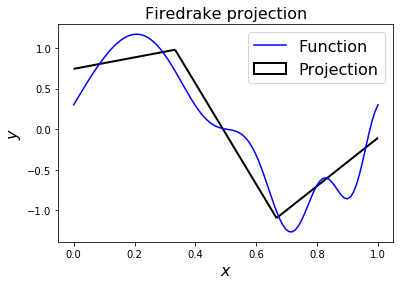

In [6]:
## Galerkin projection using Firedrake's solve

# use an in-built Firedrake function to generate a 1D mesh
mesh = fd.IntervalMesh(3, 1.0)
# define a function space on this mesh - here p/w linear continuous or "P1CG"
V = fd.FunctionSpace(mesh, "CG", 1)
# define the spatial coordinates from the mesh
x = fd.SpatialCoordinate(mesh)

# The function we want to project as a symbolic expression
f = fd.sin(2*fd.pi*x[0]) + 0.3*fd.cos(3.*2.*fd.pi*x[0]**2)

# Define test and trial function spaces for use in the weak form definition.
# The same here as we are using a "Galerkin" discretisation
u = fd.TrialFunction(V)
v = fd.TestFunction(V)

# weak or variational form of u=f
projection_eqn = u*v*fd.dx == f*v*fd.dx

# u is the trial function used to form the symbolic expression that represents the equation
# u_sol is used to store the actual numerical solution
u_sol = fd.Function(V)
# solve a u = L for u given a and L
fd.solve(projection_eqn, u_sol)

# print out the solution values at the nodes
print(u_sol.vector().array())

# plot the Firedrake derived solution against the original function
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Firedrake projection', fontsize=16)
fd.plot(u_sol, axes=ax1)

def f_fun(x):
    return np.sin(2*np.pi*x) + 0.3*np.cos(3.*2.*np.pi*x**2)

x_fine = np.linspace(0,1,100)
ax1.plot(x_fine, f_fun(x_fine), 'b-')
ax1.legend(("Function","Projection"), loc="best", fontsize=16);

[ 0.74838251  0.96677589 -1.06090952 -0.30156134]


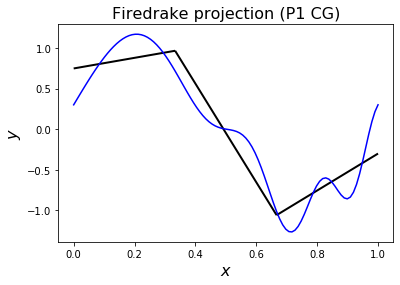

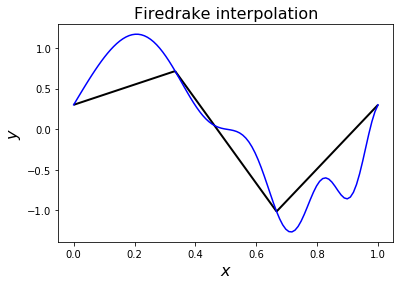

In [7]:
## Galerkin projection now using Firedrake's project

# use an in-built Firedrake function to generate a 1D mesh
mesh = fd.IntervalMesh(3, 1.0)
# define a function space on this mesh - here p/w linear continuous or "P1CG"
V = fd.FunctionSpace(mesh, "CG", 1)
# define the spatial coordinates from the mesh
x = fd.SpatialCoordinate(mesh)

# right hand side as a UFL expression
f = fd.sin( 2*fd.pi*x[0]) + 0.3*fd.cos(3.*2.*fd.pi*x[0]**2 )

# use Firedrake projection function
u_sol = fd.Function(V)
# if we do the quadrature of the RHS sufficiently accurately we can get agreement 
# with our code from above where we call simpson's rule with a lot of intervals!
u_sol.project(f, form_compiler_parameters={'quadrature_degree': 16})

# print the nodal values
print(u_sol.vector().array())

# plot the result against the original function
def f_fun(x):
    return np.sin(2*np.pi*x) + 0.3*np.cos(3.*2.*np.pi*x**2)
x_fine = np.linspace(0,1,100)
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Firedrake projection (P1 CG)', fontsize=16)
fd.plot(u_sol, axes=ax1)
ax1.plot(x_fine, f_fun(x_fine), 'b-');


# and this is how you would interpolate to the nodes
u_sol = fd.Function(V)
u_sol.interpolate(f)

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Firedrake interpolation', fontsize=16)
fd.plot(u_sol, axes=ax1)
ax1.plot(x_fine, f_fun(x_fine), 'b-');

# result from our own code above:   array([ 0.748383,  0.966776, -1.060909, -0.301561])
# we can get agreement with this with Firedrake as long as we tell it to use high enough quadrature

Let's compare this with the solution we obtained in the previous lecture and above:

<img src="figures/CG_DG_projection.png" style="width: 600px">

Let's see how simple it is to change function space and recreate the discontinuous result, to emphasise the power and convenience of using a library like this:

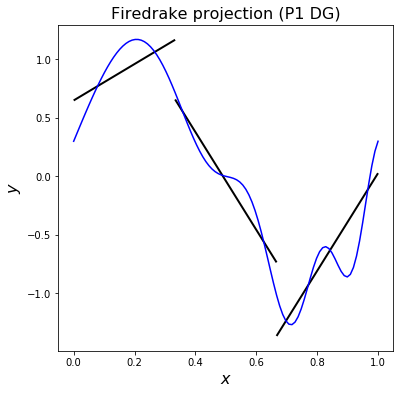

In [8]:
# use an in-built Firedrake function to generate a 1D mesh
mesh = fd.IntervalMesh(3, 1.0)
# define a function space on this mesh - here p/w linear DIScontinuous or "P1DG"
V = fd.FunctionSpace(mesh, "DG", 1)
# define the spatial coordinates from the mesh
x = fd.SpatialCoordinate(mesh)

u_sol = fd.Function(V)
u_sol.project( fd.sin(2*fd.pi*x[0]) + 0.3*fd.cos(3.*2.*fd.pi*x[0]**2) )

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Firedrake projection (P1 DG)', fontsize=16)
fd.plot(u_sol, axes=ax1)
ax1.plot(x_fine, f_fun(x_fine), 'b-');

## Solving an elliptic problem - the 2D Poisson equation

Now let's consider some actual PDEs.

Let's start with the 2D Poisson problem we considered in a previous lecture where we solved it using a finite difference method.

The continuous problem is

$$ -\nabla^2 u = f, $$

on $(x,y)\in [0,1] \times [0,1]$ where for our test case 

$$f\equiv 0,$$ 

and the following Dirichlet boundary conditions are applied:

$$u(y,0)=u(y,1)=u(x,0)=0, \;\;\;\; u(x,1) = \sin(2 \pi x),$$

i.e. the solution is inhomogeneous only on one boundary.

The exact solution to this problem is 

$$ u(x,y) = \frac{\sin(2 \pi x)\sinh(2\pi y)}{\sinh(2\pi)}.$$


### Variational form


We look for a function $u\in V$ such that the solution satisfied the weak or variational form of the problem:

$$-\int_{\Omega} \,\nabla^2 u \,v\,dx = \int_{\Gamma} \,f\,v\,dx.$$

for all test functions $v\in V$.

Integrating by parts (the higher dimensional form of the rule - see also [Green's first identity](https://en.wikipedia.org/wiki/Green%27s_identities#Green's_first_identity)) we have

$$\int_{\Omega} \,\nabla u \cdot \nabla v  \,dx - \int_{\Gamma}\,v\,\nabla u \cdot \boldsymbol{n} \,dS = \int_{\Gamma} \,f\,v\,dx,$$

where $\boldsymbol{n}$ is the unit outward normal to the domain.

In the numerical implementation of the finite dimensional problem we can assume we have applied the Dirichlet BCs by restricting the solution space. As we have seen previously (HAVE WE?) for 1D, this means the contributions due to the boundary degrees of freedom move over to the RHS and $v$ can be assumed to equal zero on the boundary. As a consequence, the boundary term vanishes (Note importantly that this is not the same reasoning for why we ignore the boundary term as a means to enforce homogeneous Neumann BCs!).

So we need to ask Firedrake to discretise and solve the weak form 

$$\int_{\Omega} \,\nabla u \cdot \nabla v  \,dx = \int_{\Gamma} \,f\,v\,dx.$$

The same equation in Firedrake is expressed as

```Python
fd.dot(fd.grad(u), fd.grad(v))*fd.dx == f*v*fd.dx
```

Note how closely this agrees with the underlying mathematical expression!

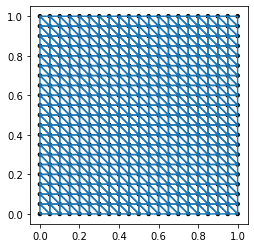

In [9]:
# Start by using an in-built Firedrake function for generating a mesh 
# (as the domain is simple)

# Number of grid points in each direction, including boundary nodes
Nx = 20
Ny = Nx

# Create square mesh of width and length 1 (use `RectangleMesh` if you want other dimensions)
# and divide it into Nx by Ny squares each divided in two triangles
mesh = fd.UnitSquareMesh(Nx, Ny)

# we can ask Firedrake to display the mesh
fd.plot(mesh);

In [10]:
# define a function space consisting of piecewise linear functions
# also known as the P1CG (Continuous Galerkin) function space
V = fd.FunctionSpace(mesh, "CG", 1)

# define the test and trial function spaces
u = fd.TrialFunction(V)
v = fd.TestFunction(V)

# right hand side
f = fd.Function(V)
f.assign( 0 )

# full equation in the weak form with all terms on the lhs, after integration by parts:
poisson_eqn = fd.dot(fd.grad(u), fd.grad(v))*fd.dx == f*v*fd.dx

# using UnitSquareMesh (or RectangleMesh), the left, right, bottom and top boundaries 
# are numbered 1, 2, 3, and 4 respectively
x, y = fd.SpatialCoordinate(mesh)
bc_top = fd.DirichletBC(V, fd.sin(2*fd.pi*x), 4)
bc_other = fd.DirichletBC(V, 0, (1,2,3))

# the function that will store the solution
u_sol = fd.Function(V)
fd.solve(poisson_eqn, u_sol, bcs=[bc_top, bc_other])

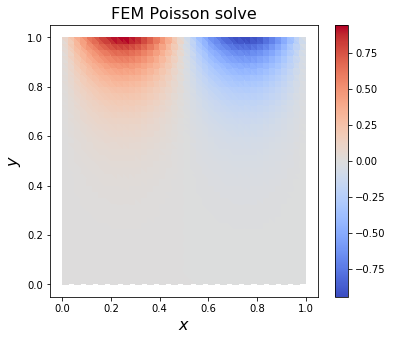

In [11]:
# let's plot our numerical solution 
# (we can compare against the analytical solution as well as that obtained with FDM)
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Poisson solve', fontsize=16)
fd.plot(u_sol, axes=ax1);

## The diffusion equation in two dimensions

Let's solve the 2D form of the diffusion equation problem we considered earlier in the domain $\Omega:=[0,1]^2$.

The strong form of the equation is

$$\frac{\partial u}{\partial t} = \kappa\, \nabla^2 u, $$

and let's assume homogeneous Dirichlet BCs on all boundaries.

For simplicity let's just ignore the $\kappa$ (pretend it's one).

### Variational form

The variational form in 1D from above was

$$ \int_I \,\frac{\partial u}{\partial t}\,v\,dx + \int_I \,u'\,v'\,dx = 0.$$

Here we've integrated by parts the second derivative and we have ignored the boundary integral due to the imposition of homogeneous Dirichlet BCs.

In 2D this takes the form

$$ \int_{\Omega} \,\frac{\partial u}{\partial t}\,v\,dx + \int_{\Omega} \,\nabla u\cdot\nabla v\,dx = 0,$$

which assuming a backward Euler discretisation in time reads

$$ \int_{\Omega} \,\frac{u^{n+1}-u^n}{\Delta t}\,v\,dx + \int_{\Omega} \,\nabla u^{n+1}\cdot\nabla v\,dx = 0.$$

In Firedrake we write (over two lines to make clear where each contribution comes from, but could also write out on a single line)
```Python
# time derivative
F =  ((u - u_old)/dt)*v*fd.dx 
# diffusion term integrated by parts
F += fd.dot(fd.grad(u), fd.grad(v))*fd.dx
```
where `F` contains all terms of the equation, which is now expressed as `F==0`. This is a linear equation that we can solve for $u^{n+1}$. To write it as a standard linear system we need to put all terms that depend on $u^{n+1}$ on the left-hand side, and all others on the right-hand side. In mathematical form the result is:

$$
\int_{\Omega} \,\frac{u^{n+1}}{\Delta t}\,v\,dx + \int_{\Omega} \,\nabla u^{n+1}\cdot\nabla v\,dx = 
\int_{\Omega} \,\frac{u^n}{\Delta t}\,v\,dx
$$

In Firedrake, we can obtain the left-hand side and right-hand side automatically via
```Python
a, L = fd.lhs(F), fd.rhs(F)
```
The equation then takes the form `a==L`.

In [12]:
# Number of grid points in each direction, including boundary nodes
Nx = 20
Ny = Nx

# Firedrake has some internal ability to general simple meshes.
# Create square mesh of width and length 1 (use RectangleMesh if you want other dimensions)
# and divide it into Nx by Ny squares each divided in two triangles
mesh = fd.UnitSquareMesh(Nx, Ny)

# define a function space consisting of piecewise linear functions
# also known as the P1CG (Continuous Galerkin) function space
V = fd.FunctionSpace(mesh, "CG", 1)

# define trial and test functions
u = fd.TrialFunction(V)
v = fd.TestFunction(V)

# Define an initial condition
x, y = fd.SpatialCoordinate(mesh)
u_old = fd.interpolate(1.0 * fd.exp( -( (x - 0.5)**2 + (y - 0.5)**2 ) / 0.005), V)

# define function that stores the solution at the new time level
u_new = fd.Function(V)

# using UnitSquareMesh (or RectangleMesh), the left, right, bottom and top boundaries 
# are numbered 1, 2, 3, and 4 respectively
bcu = fd.DirichletBC(V, 0, (1,2,3,4))

dt = 0.001
# define a firedrake constant equal to dt so that variation forms 
# not regenerated if we change the time step
k = fd.Constant(dt)

# Define weak form:
# time derivative
F =  ((u - u_old)/k)*v*fd.dx 
# diffusion term integrated by parts
F += fd.dot(fd.grad(u), fd.grad(v))*fd.dx

# split into left-hand and right-hand side
a, L = fd.lhs(F), fd.rhs(F)

# Define linear problem
# Use LinearVariationalProblem (and solver) objects to avoid reassembling the
# LHS matrix each step
prob1 = fd.LinearVariationalProblem(a, L, u_new, bcs=bcu)

# Define corresponding solver options (option below corresponds to a direct LU solver)
solver1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})

# time stepping parameters
t = 0.
t_end = 0.01

# time step
while t < t_end:
    t += dt
    solver1.solve()
    # copy new solution into u_n for next time step
    u_old.assign(u_new)
    if( np.abs( t - np.round(t,decimals=3) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))  

time = 0.001
time = 0.002
time = 0.003
time = 0.004
time = 0.005
time = 0.006
time = 0.007
time = 0.008
time = 0.009
time = 0.010


**Question:** How could we update the code above to use forward Euler, and why might the simulation go unstable without a smaller time step?

Again we can plot the results using `fd.plot`.

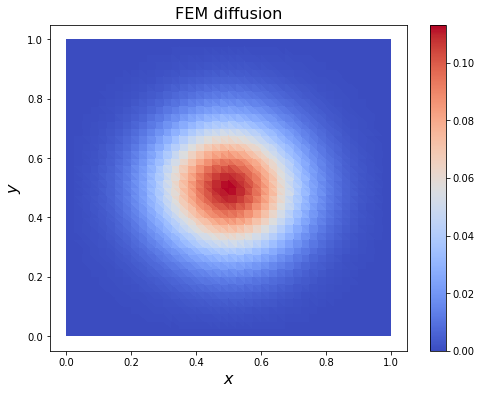

In [13]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM diffusion', fontsize=16)
fd.plot(u_new, axes=ax1);

## The advection equation in two dimensions

This equation describes the advection of a scalar according to a prescribed velocity field $\vec u$. Since we are now using $\vec u$ for the velocity field, let's use $q$ for the scalar field that we solve for (the trial function) which we search for in some function space $V$ (for instance the space of all piecewise linear functions)

$$
  \frac{\partial q}{\partial t} + \vec u\cdot \nabla q = 0
$$

In the weak form, we will use $\phi$ for the test function, and say

$$
  \int_\Omega \frac{\partial q}{\partial t}\phi \, \mathrm{d}x
    + \int_\Omega \left(\vec{u}\cdot\nabla q\right)\phi ~ \mathrm{d}x = 0
$$

for every test function $\phi\in V$. As usual, we integrate this by parts

$$
  \int_\Omega \frac{\partial q}{\partial t}\phi \, \mathrm{d}x - L(q, \vec u, \phi) = 0, \\
    \text{where }L(q, \vec u, \phi) = 
    \int_\Omega q \nabla \cdot\left(\vec{u}\phi\right) ~ \mathrm{d}x
  - \int_{\partial\Omega} q\vec u\cdot\vec n\phi ~ \mathrm{d}s = 0,
$$

Again, integration by parts introduces a boundary term, the integral over the boundary $\partial\Omega$, which can be used to impose boundary conditions. In pure advection problems we should only apply a Dirichlet boundary condition $q=q_{\text{in}}$ on the incoming boundaries. If we assume that the normal vector $\vec n$ is always pointing out of the domain, the incoming boundaries are determined by $\vec u\cdot\vec n\lt0$. At this part of the boundary we replace $q$ with the imposed boundary value $q_{\text{in}}$, and on all other parts we leave $q$ as it is.
Thus the boundary term becomes

$$
  -\int_{\partial\Omega} q_b\vec u\cdot\vec n\phi ~ \mathrm{d}s = 0, \quad
  q_b = \begin{cases}q_{\text{in}} &  \vec u\cdot\vec n\lt 0 \\ q & \vec u\cdot\vec n\geq 0\end{cases}
$$

### Runge-Kutta time integration
We will use a slightly more sophisticated, three stage Runge-Kutta time integration scheme here,
in which we solve three equations:

$$
\int_\Omega \Delta q_0 \phi \, \mathrm{d}x = \Delta t~L(q_0, \vec u, \phi) \\
\int_\Omega \Delta q_1 \phi \, \mathrm{d}x = \Delta t~L(q_1, \vec u, \phi) \\
\int_\Omega \Delta q_2 \phi \, \mathrm{d}x = \Delta t~L(q_2, \vec u, \phi)
$$

for respectively $\Delta q_0, \Delta q_1,$ and $\Delta q_2$, in which $q_0 = q^n$ (the solution from the previous time step), $q_1=q_0+\Delta q_0$, and $q_2=\tfrac 34 q_0+\tfrac 14\left(q_1+\Delta q_1\right)$. Finally the new solution at the end of the current time step is given by $q^{n+1}=\tfrac 13 q_0 + \tfrac 23\left(q_2+\delta q_2\right)$.

### Initial condition and velocity field
We will investigate the properties of a Continuous Galerkin (CG) advection scheme advecting a bell shaped initial condition in the usual unit square domain. The velocity field is a simple rotation around the centre of the domain $(0.5, 0.5)$. To the bell-shaped initial condition, which is zero outside the bell, we add the value of one. This means the scalar is one near the boundaries, which we maintain by using a boundary value of $q_in=1$ as well.

In [ ]:
# the mesh: a unit square divided in 40x40x2 triangles
Nx = 40
Ny = Nx
mesh = fd.UnitSquareMesh(Nx, Ny)

# the function space in which we find the solution:
V = fd.FunctionSpace(mesh, "CG", 1)
# the function space used for the velocity field:
W = fd.VectorFunctionSpace(mesh, "CG", 1)

# the velocity field is a simple counter clockwise rotation around (0.5, 0.5)
x, y = fd.SpatialCoordinate(mesh)
velocity = fd.as_vector((0.5 - y, x - 0.5))
u = fd.Function(W).interpolate(velocity)

# the initial condition for the scalar function
bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
bell = 0.25*(1+fd.cos(fd.pi*fd.min_value(fd.sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))

q = fd.Function(V).interpolate(1.0 + bell)
q_init = fd.Function(V).assign(q)

# We will run for time `2\pi`, a full rotation.  We take 600 steps, giving
# a timestep close to the CFL limit.  We declare an extra variable ``dtc``; for
# technical reasons, this means that Firedrake does not have to compile new C code
# if the user tries different timesteps.  Finally, we define the inflow boundary
# condition, q = q_in.
T = 2*fd.pi
dt = T/600.0
dtc = fd.Constant(dt)
q_in = fd.Constant(1.0)

Let's plot these:

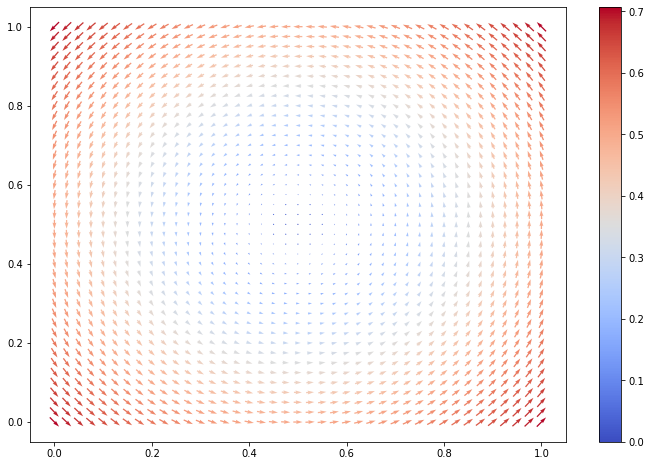

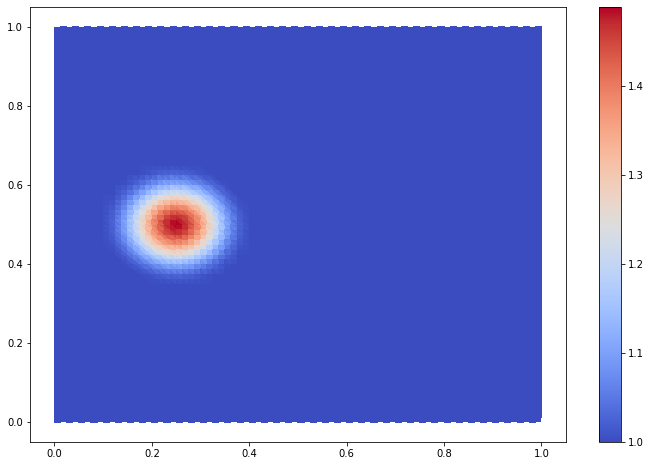

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
fd.plot(u, axes=ax);
fig, ax = plt.subplots(figsize=(12,8))
fd.plot(q_init, axes=ax);

0.07064725985693392


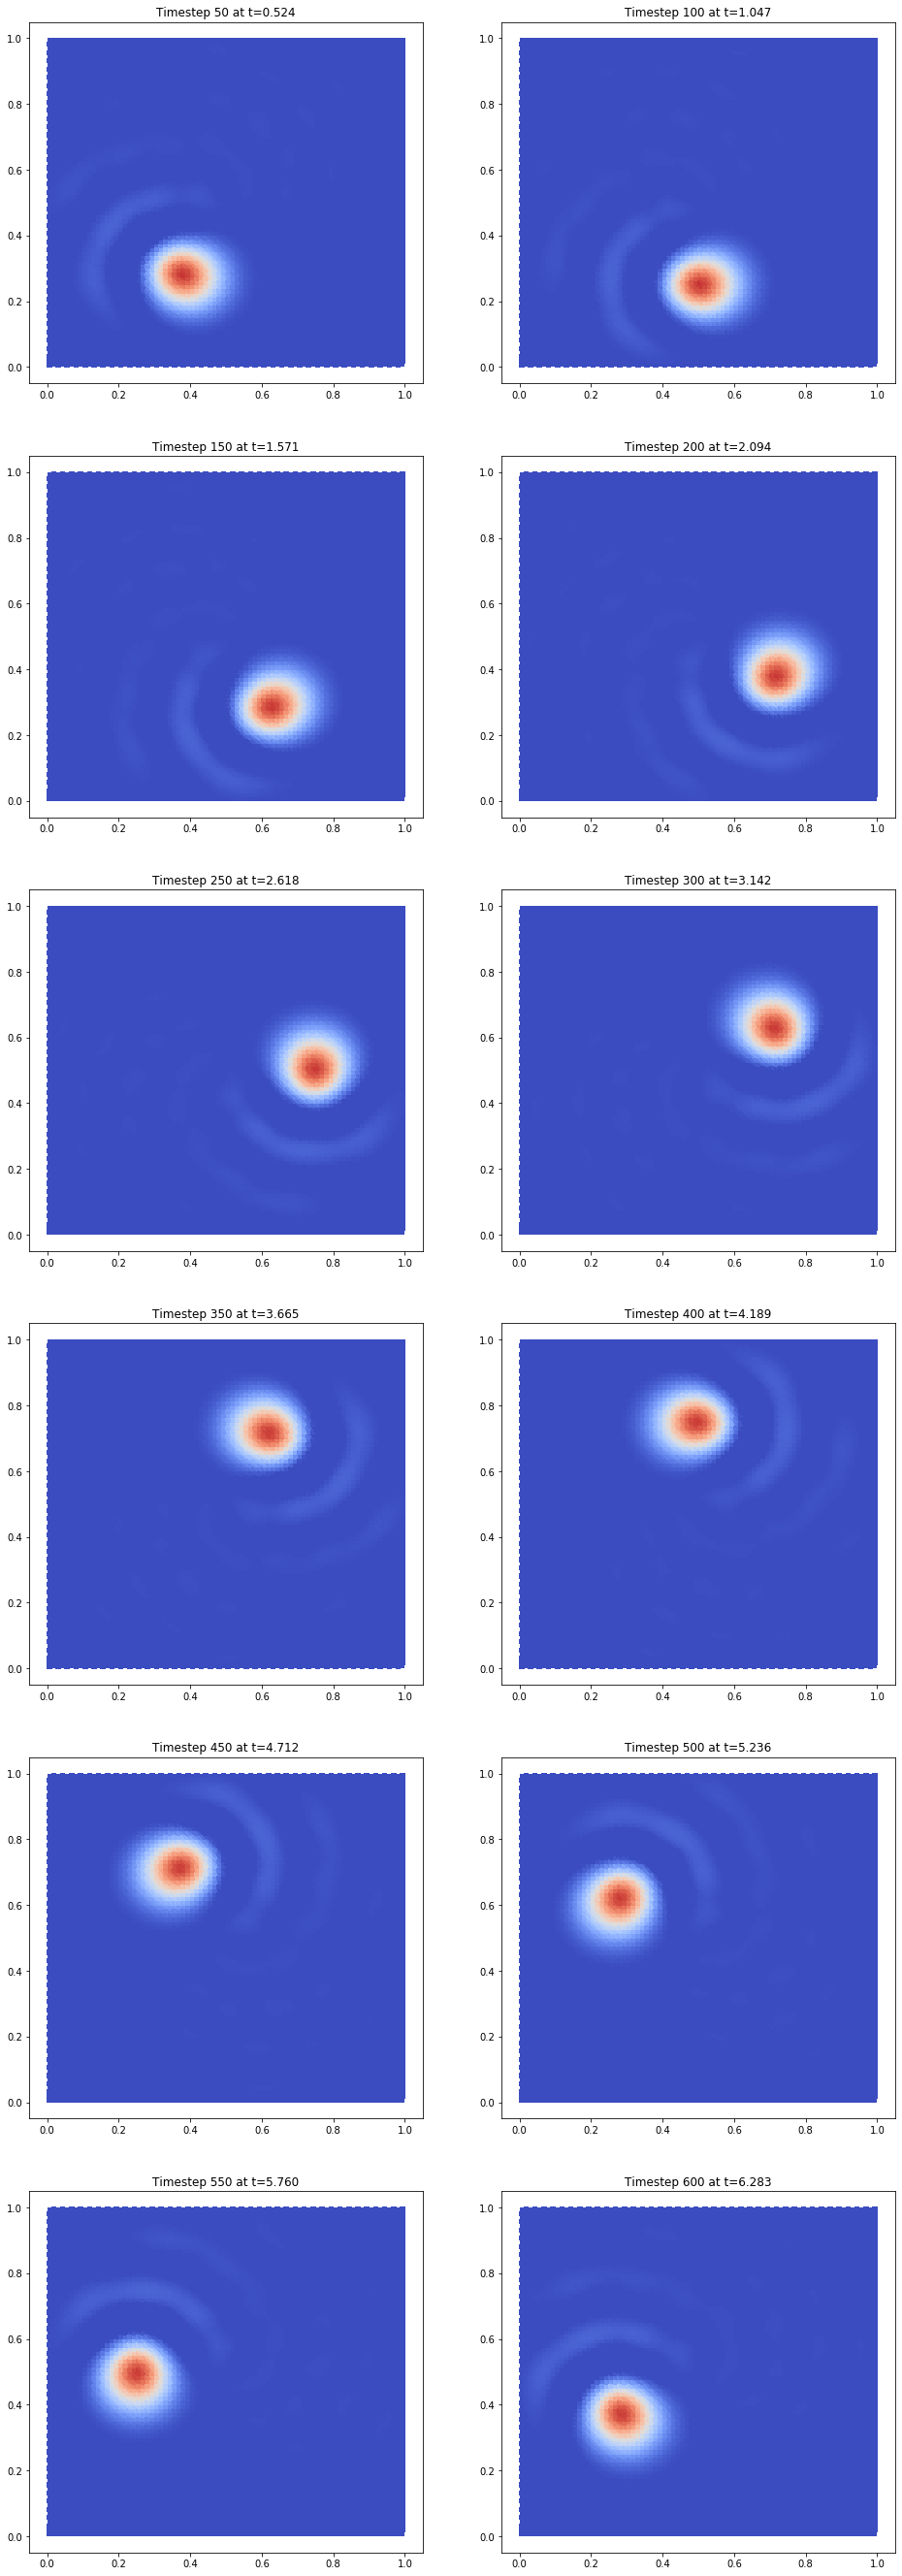

In [44]:
# Now we declare our variational forms.  Solving for dq (\Delta q) at each
# stage, the explicit timestepping scheme means that the left-hand side is just a
# mass matrix.

dq_trial = fd.TrialFunction(V)
phi = fd.TestFunction(V)
a = phi*dq_trial*fd.dx

# The right-hand-side is more interesting.

# FacetNormal gives us the normal to the boundary edges, which we call n as usual
n = fd.FacetNormal(mesh)

# the RHS for the first Runge Kutta stage, using q from the previous timestep
L1 = dtc*(q*fd.div(phi*u)*fd.dx
          - fd.conditional(fd.dot(u, n) < 0, phi*fd.dot(u, n)*q_in, 0.0)*fd.ds
          - fd.conditional(fd.dot(u, n) > 0, phi*fd.dot(u, n)*q, 0.0)*fd.ds)

# as can be seen from the formulae above the RHS for stages 2 and 3
# can be obtained by simply replacing q with q1 and q2 resp.
q1 = fd.Function(V); q2 = fd.Function(V)
L2 = fd.replace(L1, {q: q1}); L3 = fd.replace(L1, {q: q2})

# We now declare a variable to hold the temporary increments at each stage.
dq = fd.Function(V)

# Since we want to perform hundreds of timesteps, ideally we should avoid
# reassembling the left-hand-side mass matrix each step, as this does not change.
# We therefore make use of the ``LinearVariationalProblem`` and
# ``LinearVariationalSolver`` objects for each of our Runge-Kutta stages. These
# cache and reuse the assembled left-hand-side matrix. 

prob1 = fd.LinearVariationalProblem(a, L1, dq)
solv1 = fd.LinearVariationalSolver(prob1)
prob2 = fd.LinearVariationalProblem(a, L2, dq)
solv2 = fd.LinearVariationalSolver(prob2)
prob3 = fd.LinearVariationalProblem(a, L3, dq)
solv3 = fd.LinearVariationalSolver(prob3)

# we plot the solution every other `nsteps` timesteps
nsteps = 50

# estimate the number of rows of figures we need
nrows = int(np.ceil(T/dt/nsteps/2))
fig, axes  = plt.subplots(nrows, 2, figsize=(16, 8*nrows))
axes = axes.flatten()

t = 0.0
step = 0
while t < T - 0.5*dt:
    solv1.solve()
    q1.assign(q + dq)

    solv2.solve()
    q2.assign(0.75*q + 0.25*(q1 + dq))

    solv3.solve()
    q.assign((1.0/3.0)*q + (2.0/3.0)*(q2 + dq))

    step += 1
    t += dt

    if step % nsteps == 0:
        ax = axes[step//nsteps-1]
        fd.plot(q, axes=ax, cmap=None)
        # set the colormap:
        cbar = ax.collections[-1].set_clim(1, 1.5)
        cbar = ax.collections[-1].set_cmap(cm.coolwarm)
        ax.title.set_text('Timestep %d at t=%.3f' % (step, t))


# Finally, we display the normalised :math:`L^2` error, by comparing to the
# initial condition. ::

L2_err = fd.sqrt(fd.assemble((q - q_init)*(q - q_init)*fd.dx))
L2_init = fd.sqrt(fd.assemble(q_init*q_init*fd.dx))
print(L2_err/L2_init)

# Incompressible Navier-Stokes (CFD) examples using Firedrake

For details of the form of the Navier-Stokes equations considered here and the discretisation (IPCS) employed here see chapter 21 ("A comparison of finite element schemes for the incompressible Navier–Stokes equations") of the [FEniCS book](https://launchpadlibrarian.net/83776282/fenics-book-2011-10-27-final.pdf).

**Aside:** [FEniCS](https://fenicsproject.org/) is a project very similar in nature to Firedrake (i.e. the automated solution of PDEs via the FEM) and much of the syntax (namely the Python API; the DSL for specifying the weak form of PDEs is called [UFL](https://fenics.readthedocs.io/projects/ufl/en/latest/) - a component of FEniCS) is common so you can learn a lot about Firedrake from FEniCS.

The incompressible Navier Stokes equations are given by a momentum equation:

$$
  \newcommand{\tsigma}{\bar{\bar\sigma}}
  \frac{\partial\vec u}{\partial t} + \vec u\cdot\nabla \vec u - \nabla\cdot\tsigma(\vec u, p) = f,
  \tag{NS1} \label{NS1}
$$

coupled to the incompressibility condition:

$$
  \nabla\cdot\vec u = 0, \tag{NS2} \label{NS2}
$$

where $\tsigma(\vec u, p)$ is the stress tensor given by

$$
  \tsigma(\vec u, p) = \nu\left[\nabla\vec u + \left(\nabla \vec u\right)^T\right] - p~{\mathbf I}
$$

with kinematic viscosity $\nu$. Equations $\eqref{NS1}$ and $\eqref{NS2}$ are solved for velocity $\vec u$ and pressure $p$ but note that we do not have an independent equation associated with $p$.

There are various approaches to solving these coupled equations, many based on the idea of a pressure projection or  correction. Here, we follow here the IPCS method, which involves three steps:

1. Solve for an intermediate velocity $\vec u^*$ using the pressure from the previous timestep $p^n$:

$$
\frac{\vec u^* - \vec u^n}{\Delta t} + \vec u^n\cdot\nabla \vec u^n - \nabla\cdot\tsigma\left(\frac{\vec u^* + \vec u^n}2, p^n\right) = f
$$

2. Solve for the new pressure $p^{n+1}$ using a pressure Poisson equation:

$$
  \nabla^2 p^{n+1} = \nabla^2 p^n + \frac 1{\Delta t}\nabla\cdot\vec u^*
$$

3. Apply a correction to $\vec u^*$ to obtain the new velocity $\vec u^{n+1}$

$$
  \vec u^{n+1} = \vec u^* - \frac{p^{n+1}-p^n}{\Delta t}
$$

For the FEM, the above three equation need to be reformulated into weak form with careful consideration of the boundary terms.  For more details see the the [FEniCS book](https://launchpadlibrarian.net/83776282/fenics-book-2011-10-27-final.pdf).  

## Pressure driven channel

In this problem we look at the flow in a channel section driven by a pressure difference between the two open ends of the channel. The side boundaries are assigned a no-slip boundary condition. We expect a quadratic velocity profile across the channel.

In [13]:
print("Setting up solver.")

# physical constants
nu = fd.Constant(1)

# time step
dt = 0.05
# define a firedrake constant equal to dt so that variation forms 
# not regenerated if we change the time step
k = fd.Constant(dt)

# mesh
Nx = 10
Ny = Nx
mesh = fd.UnitSquareMesh(Nx, Ny)

# function spaces
V = fd.VectorFunctionSpace(mesh, "CG", 2)
Q = fd.FunctionSpace(mesh, "CG", 1)

# define trial and test functions
u = fd.TrialFunction(V)
v = fd.TestFunction(V)

p = fd.TrialFunction(Q)
q = fd.TestFunction(Q)

u_now = fd.Function(V)
u_next = fd.Function(V)
u_star = fd.Function(V)
p_now = fd.Function(Q)
p_next = fd.Function(Q)

# Expressions for the variational forms
n = fd.FacetNormal(mesh)
f = fd.Constant((0.0, 0.0))
u_mid = 0.5*(u_now + u)

def sigma(u, p):
    """Stress tensor"""
    return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))

# Define boundary conditions
# pressure BCs 
bcu = fd.DirichletBC(V, fd.Constant((0.0, 0.0)), (3, 4))  # no slip on walls
bcp = [fd.DirichletBC(Q, fd.Constant(8.0), 1),  # inflow pressure of 8
       fd.DirichletBC(Q, fd.Constant(0.0), 2)]  # outflow pressure of 0

# Define variational forms 
# The Navier-Stokes momentum equation ...
# time derivative
F1 = fd.inner((u - u_now)/k, v) * fd.dx \
# advection (fully explicit)
F1 += fd.inner(fd.dot(u_now, fd.nabla_grad(u_now)), v) * fd.dx \
# stress (Crank-Nicolson for viscosity, explicit for pressure)
F1 += fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
# pressure boundary term
F1 += fd.inner(p_now * n, v) * fd.ds \
# diffusion boundary term
F1 -= fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
# source term
F1 -= fd.inner(f, v) * fd.dx

a1, L1 = fd.system(F1)

# variational form corresponding to the pressure Poisson equation
a2 = fd.inner(fd.nabla_grad(p), fd.nabla_grad(q)) * fd.dx
L2 = fd.inner(fd.nabla_grad(p_now), fd.nabla_grad(q)) * fd.dx \
    - (1/k) * fd.inner(fd.div(u_star), q) * fd.dx

# variational form corresponding to the velocity update
a3 = fd.inner(u, v) * fd.dx
L3 = fd.inner(u_star, v) * fd.dx \
     - k * fd.inner(fd.nabla_grad(p_next - p_now), v) * fd.dx

# Define linear problems
prob1 = fd.LinearVariationalProblem(a1, L1, u_star, bcs=bcu)
prob2 = fd.LinearVariationalProblem(a2, L2, p_next, bcs=bcp)
prob3 = fd.LinearVariationalProblem(a3, L3, u_next)

# Define solvers. ksp_type is a Petsc keyword to define the solver, pc_type the preconditioner
solver1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'gmres', 'pc_type': 'sor'}) 
solver2 = fd.LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'cg', 'pc_type': 'gamg'}) 
solver3 = fd.LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'}) 

# Prep for saving solutions
u_save = fd.Function(V).assign(u_now)
p_save = fd.Function(Q).assign(p_now)
outfile_u = fd.File("outputs/channel/u.pvd")
outfile_p = fd.File("outputs/channel/p.pvd")
outfile_u.write(u_save)
outfile_p.write(p_save)

# Time loop
t = 0.0
t_end = 10.0

print("Beginning time loop...")

#for steps in range(num_steps):
while t < t_end:
    solver1.solve()
    solver2.solve()
    solver3.solve()

    t += dt

    u_save.assign(u_next)
    p_save.assign(p_next)
    outfile_u.write(u_save)
    outfile_p.write(p_save)

    # update solutions
    u_now.assign(u_next)
    p_now.assign(p_next)
    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")

Setting up solver.
Beginning time loop...
time = 1.000
time = 2.000
time = 3.000
time = 4.000
time = 5.000
time = 6.000
time = 7.000
time = 8.000
time = 9.000
time = 10.000
Simulation complete


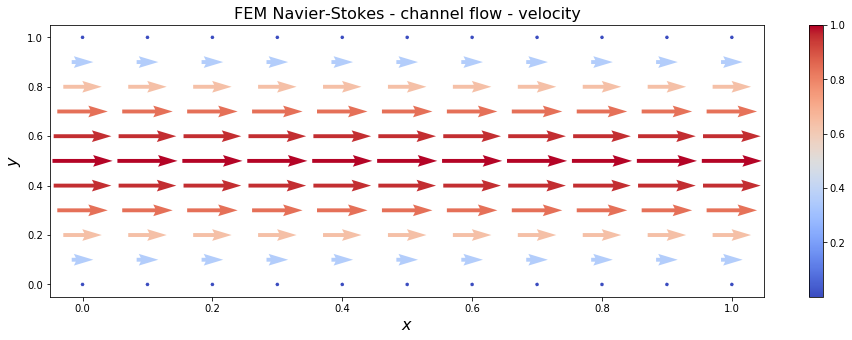

In [14]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(u_now,axes=ax1);

RMS error =  2.84487554367399e-05


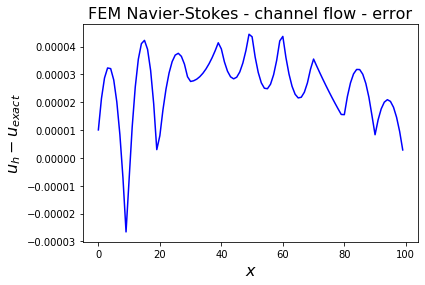

In [15]:
# compute and plot an error based on exact solution being a quadratic
N = 100
locs = np.zeros((N,2))
locs[:,0] = 0.5*np.ones(N)
locs[:,1] = np.linspace(0.01,0.99,N)

ux_locs = u_now.at(locs)
ux = [ux_loc[0] for ux_loc in ux_locs]

y = locs[:,1]
ux_exact = 4*y*(1-y)
error = np.linalg.norm(ux - ux_exact) / np.sqrt(len(ux))
print('RMS error = ',error)
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u_h - u_{exact}$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - error', fontsize=16)
ax1.plot(ux - ux_exact, 'b-');

## Lid driven cavity

The lid driven cavity is a standard problem in which a tangential velocity is prescribed at the top of a square domain. The left, right and bottom boudary are assigned a no-slip boundary condition. Note that this implies a discontinuity in the top-left and top-right corners of the domain. The solution is determined by the viscosity, here we choose $\nu=0.01$ giving a Reynolds number of $\mathrm{Re}=U L/\nu=100$; U and L are representative velocity and length scales which are both one, as we solve in a unit square domain with a prescribed top velocity of 1 m/s.

In [16]:
print("Setting up solver.")

# physical constants
nu = fd.Constant(0.01)

# time step
dt = 0.01
# define a firedrake constant equal to dt so that variation forms 
# not regenerated if we change the time step
k = fd.Constant(dt)

# Number of grid points in each direction, including boundary nodes
Nx = 100
Ny = Nx

# Firedrake has some internal ability to general simple meshes.
# Create square mesh of width and length 1 (use RectangleMesh if you want other dimensions)
# and divide it into Nx by Ny squares each divided in two triangles
mesh = fd.UnitSquareMesh(Nx, Ny)

V = fd.VectorFunctionSpace(mesh, "CG", 2)
Q = fd.FunctionSpace(mesh, "CG", 1)

u = fd.TrialFunction(V)
v = fd.TestFunction(V)

p = fd.TrialFunction(Q)
q = fd.TestFunction(Q)

u_now = fd.Function(V)
u_next = fd.Function(V)
u_star = fd.Function(V)
p_now = fd.Function(Q)
p_next = fd.Function(Q)

# Expressions for the variational forms
n = fd.FacetNormal(mesh)
f = fd.Constant((0.0, 0.0))
u_mid = 0.5*(u_now + u)

def sigma(u, p):
    return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))

# Define boundary conditions
bcu = [fd.DirichletBC(V, fd.Constant((0.0, 0.0)), (1, 2, 3)), # bottom, left and right
          fd.DirichletBC(V, fd.Constant((1.0, 0.0)), 4)] # top

# Define variational forms - see the comments above
F1 = fd.inner((u - u_now)/k, v) * fd.dx \
    + fd.inner(fd.dot(u_now, fd.nabla_grad(u_mid)), v) * fd.dx \
    + fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
    + fd.inner(p_now * n, v) * fd.ds \
    - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
    - fd.inner(f, v) * fd.dx

a1, L1 = fd.system(F1)

a2 = fd.inner(fd.nabla_grad(p), fd.nabla_grad(q)) * fd.dx
L2 = fd.inner(fd.nabla_grad(p_now), fd.nabla_grad(q)) * fd.dx \
    - (1/k) * fd.inner(fd.div(u_star), q) * fd.dx

a3 = fd.inner(u, v) * fd.dx
L3 = fd.inner(u_star, v) * fd.dx \
     - k * fd.inner(fd.nabla_grad(p_next - p_now), v) * fd.dx

# Define linear problems
prob1 = fd.LinearVariationalProblem(a1, L1, u_star, bcs=bcu)
prob2 = fd.LinearVariationalProblem(a2, L2, p_next)
prob3 = fd.LinearVariationalProblem(a3, L3, u_next, bcs=bcu)

# Define solvers
solve1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'gmres', 'pc_type': 'sor'})
# deal with the nullspace in the pressure solve (due to Neumann BCs on all boundaries)
nullspace = fd.VectorSpaceBasis(constant=True)
solve2 = fd.LinearVariationalSolver(prob2, nullspace=nullspace, transpose_nullspace=nullspace, solver_parameters={'ksp_type': 'cg', 'pc_type': 'hypre'})
solve3 = fd.LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'})

# Prep for saving solutions
u_save = fd.Function(V).assign(u_now)
p_save = fd.Function(Q).assign(p_now)
outfile_u = fd.File("outputs/LDC/u.pvd")
outfile_p = fd.File("outputs/LDC/p.pvd")
outfile_u.write(u_save)
outfile_p.write(p_save)

# Time loop
t = 0.0
t_end = 20

print("Beginning time loop...")

while t < t_end:
    solve1.solve()
    solve2.solve()
    solve3.solve()

    t += dt

    u_save.assign(u_next)
    p_save.assign(p_next)
    outfile_u.write(u_save)
    outfile_p.write(p_save)

    # update solutions
    u_now.assign(u_next)
    p_now.assign(p_next)
    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")

Setting up solver.
Beginning time loop...
time = 1.000
time = 2.000
time = 3.000
time = 4.000
time = 5.000
time = 6.000
time = 7.000
time = 8.000
time = 9.000
time = 10.000
time = 11.000
time = 12.000
time = 13.000
time = 14.000
time = 15.000
time = 16.000
time = 17.000
time = 18.000
time = 19.000
time = 20.000
Simulation complete


(-0.05, 1.05, -0.05, 1.05)

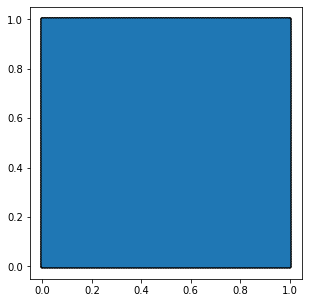

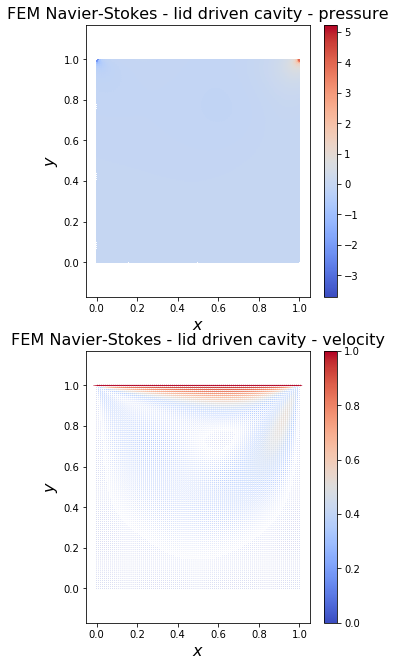

In [17]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)
fd.plot(mesh, axes=ax1)

fig = plt.figure(figsize=(5, 11))
fig.tight_layout(w_pad=6, h_pad=6)
ax1 = fig.add_subplot(211)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - lid driven cavity - pressure', fontsize=16)
fd.plot(p_now,axes=ax1)
ax1.axis('equal')
ax1 = fig.add_subplot(212)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - lid driven cavity - velocity', fontsize=16)
fd.plot(u_now,axes=ax1)
ax1.axis('equal')

We compare the data against a published benchmark

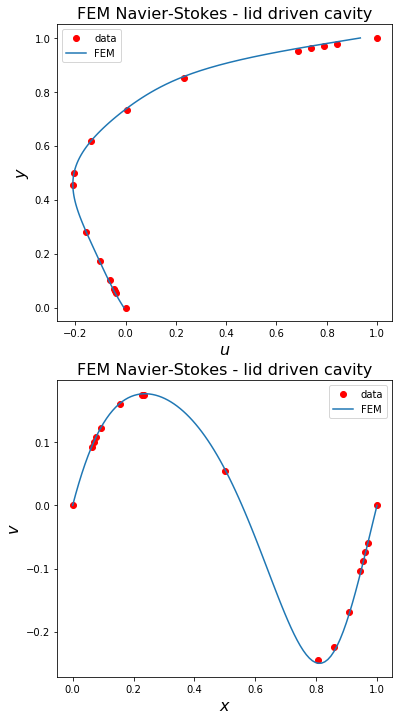

In [21]:
# benchmark data from
# Ghia, U., Ghia, K. N. & Shin, C. T. 
# High-Re solutions for incompressible flow 
# using the Navier-Stokes equations and a multigrid method. 
# J. Comput. Phys. 48, 387–411 (1982).

Ghia_Re100_u = np.array([[1.0, 1.0],
                         [0.9766, 0.84123],
                         [0.9688, 0.78871],
                         [0.9609, 0.73722],
                         [0.9531, 0.68717],
                         [0.8516, 0.23151],
                         [0.7344, 0.00332],
                         [0.6172, -0.13641],
                         [0.5000, -0.20581],
                         [0.4531, -0.21090],
                         [0.2813, -0.15662],
                         [0.1719, -0.10150],
                         [0.1016, -0.06434],
                         [0.0703, -0.04775],
                         [0.0625, -0.04192],
                         [0.0547, -0.03717],
                         [0.0000, 0.000000]])

Ghia_Re100_v = np.array([[1.0, 0.0],
                         [0.9688, -0.05906],
                         [0.9609, -0.07391],
                         [0.9531, -0.08864],
                         [0.9453, -0.10313],
                         [0.9063, -0.16914],
                         [0.8594, -0.22445],
                         [0.8047, -0.24533],
                         [0.5000, 0.05454],
                         [0.2344, 0.17527],
                         [0.2266, 0.17507],
                         [0.1563, 0.16077],
                         [0.0938, 0.12317],
                         [0.0781, 0.10890],
                         [0.0703, 0.10091],
                         [0.0625, 0.09233],
                         [0.0000, 0.00000]])

N = 100
fig = plt.figure(figsize=(6, 12))
fig.tight_layout(w_pad=6, h_pad=6)
ax1 = fig.add_subplot(211)
ax1.set_xlabel('$u$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - lid driven cavity', fontsize=16)
ax1.plot(Ghia_Re100_u[:,1],Ghia_Re100_u[:,0],'ro',label='data')

locs1 = np.zeros((N,2))
locs1[:,0] = 0.5*np.ones(N)
locs1[:,1] = np.linspace(1.e-6,1-1.e-6,N)
ux = [u_now.at(locs)[i][0] for i in range(N)]
ax1.plot(ux, locs1[:,1], label='FEM')
ax1.legend(loc="best")

ax1 = fig.add_subplot(212)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$v$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - lid driven cavity', fontsize=16)
ax1.plot(Ghia_Re100_v[:,0],Ghia_Re100_v[:,1],'ro',label='data')

locs2 = np.zeros((N,2))
locs2[:,0] = np.linspace(1.e-6,1-1.e-6,N)
locs2[:,1] = 0.5*np.ones(N)
uy = [u_now.at(locs2)[i][1] for i in range(N)]
ax1.plot(locs2[:,0], uy, label='FEM')
ax1.legend(loc="best");

## Flow past a cylinder

Flow past a cylinder is a very classical CFD test problem.

The geometry is a circle cut out of a rectangle. This is sufficiently complex that we need to make use of a dedicated piece of mesh generation software, e.g. [*Gmsh*](http://gmsh.info/) is good and free!

### Geometry description and mesh generation

The following is a `Gmsh` input file ("cylinder.geo") which can be run with the command `gmsh -2 cylinder.geo`.


```
// far field resolution
dx1 = 0.05;
// resolution at cylinder
dx2 = 0.01;

// 4 corners of rectangle
Point(1) = {0, 0, 0, dx1};
Point(2) = {2.2, 0, 0, dx1};
Point(3) = {0, 0.41, 0, dx1};
Point(4) = {2.2, 0.41, 0, dx1};
// define circle, centre then two points either side
Point(5) = {0.15, 0.2, -0, dx2};
Point(6) = {0.25, 0.2, -0, dx2};
Point(7) = {0.2, 0.2, 0, dx1};

// define the rectange
Line(1) = {3, 4};
Line(2) = {4, 2};
Line(3) = {2, 1};
Line(4) = {1, 3};

// define the circle
Circle(5) = {5, 7, 6};
Circle(6) = {6, 7, 5};

Line Loop(9) = {1, 2, 3, 4, -5, -6};
Plane Surface(9) = {9};

//top(1) and bottom(3)
Physical Line(1) = {1, 3};
// inflow  
Physical Line(2) = {4};
//outflow
Physical Line(3) = {2};
//circle
Physical Line(4) = {5, 6};

// Whole domain id
Physical Surface(9) = {9};
```

NB. the numbers 1, 2, 3, and 4 are the labels we use to specify BCs (not the same as the Firedrake defauly 1-4 we used earlier). 

It's important we use the correct numbers in the Firedrake code otherwise we could be applying the inflow BC on the wrong boundary - it's good practice to document your meshing files.

In [24]:
# run the gmsh command that a mesh file cylinder.msh from the input cylinder.geo
# this is a terminal command so we need to prepend it with a !
!gmsh -2 cylinder.geo

Info    : Running 'gmsh -2 cylinder.geo' [Gmsh 3.0.6, 1 node, max. 1 thread]
Info    : Started on Wed Jun 26 13:46:40 2019
Info    : Reading 'cylinder.geo'...
Info    : Starting subloop 1 in Line Loop 9 (are you sure about this?)
Info    : Done reading 'cylinder.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Done meshing 1D (0.000633 s)
Info    : Meshing 2D...
Info    : Meshing surface 9 (Plane, Delaunay)
Info    : Done meshing 2D (0.022658 s)
Info    : 723 vertices 1451 elements
Info    : Writing 'cylinder.msh'...
Info    : Done writing 'cylinder.msh'
Info    : Stopped on Wed Jun 26 13:46:40 2019


In [35]:
print("Setting up solver.")

# physical constants
nu = fd.Constant(0.001)

# time step
dt = 0.001
# define a firedrake constant equal to dt so that variation forms 
# not regenerated if we change the time step
k = fd.Constant(dt)

# instead of using RectangleMesh, we now read the mesh from file
mesh = fd.Mesh("cylinder.msh")

V = fd.VectorFunctionSpace(mesh, "CG", 2)
Q = fd.FunctionSpace(mesh, "CG", 1)

u = fd.TrialFunction(V)
v = fd.TestFunction(V)

p = fd.TrialFunction(Q)
q = fd.TestFunction(Q)

u_now = fd.Function(V)
u_next = fd.Function(V)
u_star = fd.Function(V)
p_now = fd.Function(Q)
p_next = fd.Function(Q)

# Expressions for the variational forms
n = fd.FacetNormal(mesh)
f = fd.Constant((0.0, 0.0))
u_mid = 0.5*(u_now + u)

def sigma(u, p):
    return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))


x, y = fd.SpatialCoordinate(mesh)

# Define boundary conditions
bcu = [fd.DirichletBC(V, fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
          fd.DirichletBC(V, ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
bcp = [fd.DirichletBC(Q, fd.Constant(0), 3)]  # outflow

# Define variational forms
F1 = fd.inner((u - u_now)/k, v) * fd.dx \
    + fd.inner(fd.dot(u_now, fd.nabla_grad(u_mid)), v) * fd.dx \
    + fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
    + fd.inner(p_now * n, v) * fd.ds \
    - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
    - fd.inner(f, v) * fd.dx

a1, L1 = fd.system(F1)

a2 = fd.inner(fd.nabla_grad(p), fd.nabla_grad(q)) * fd.dx
L2 = fd.inner(fd.nabla_grad(p_now), fd.nabla_grad(q)) * fd.dx \
    - (1/k) * fd.inner(fd.div(u_star), q) * fd.dx

a3 = fd.inner(u, v) * fd.dx
L3 = fd.inner(u_star, v) * fd.dx \
     - k * fd.inner(fd.nabla_grad(p_next - p_now), v) * fd.dx

# Define linear problems
prob1 = fd.LinearVariationalProblem(a1, L1, u_star, bcs=bcu)
prob2 = fd.LinearVariationalProblem(a2, L2, p_next, bcs=bcp)
prob3 = fd.LinearVariationalProblem(a3, L3, u_next)

# Define solvers
solve1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'gmres', 'pc_type': 'sor'})  
solve2 = fd.LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'cg', 'pc_type': 'gamg'})  
solve3 = fd.LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'})  

# Prep for saving solutions
u_save = fd.Function(V).assign(u_now)
p_save = fd.Function(Q).assign(p_now)
outfile_u = fd.File("outputs/cylinder/u.pvd")
outfile_p = fd.File("outputs/cylinder/p.pvd")
outfile_u.write(u_save)
outfile_p.write(p_save)

# Time loop
t = 0.0
t_end = 5.

print("Beginning time loop...")

u_list = []
while t < t_end :
    solve1.solve()
    solve2.solve()
    solve3.solve()

    t += dt

    u_save.assign(u_next)
    p_save.assign(p_next)
    outfile_u.write(u_save)
    outfile_p.write(p_save)
    
    u_list.append(fd.Function(u_next))

    # update solutions
    u_now.assign(u_next)
    p_now.assign(p_next)

    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")

Setting up solver.
Beginning time loop...
time = 1.000
time = 2.000
time = 3.000
time = 4.000
time = 5.000
Simulation complete


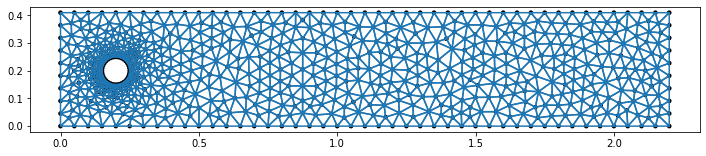

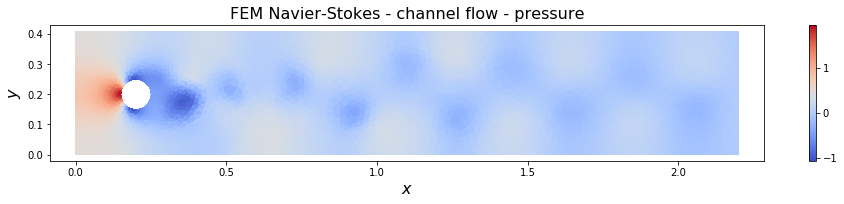

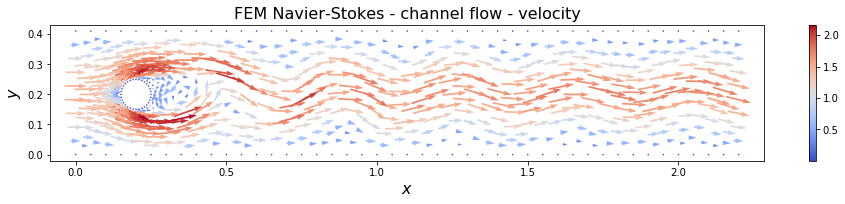

In [27]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
fd.plot(mesh, axes=ax1)

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(p_now,axes=ax1)
ax1.axis('equal')

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(u_now,axes=ax1)
ax1.axis('equal');

## Backward facing step

Another very classical CFD test case is flow over a backwards facing step. Note that in this and the previous example, we are using a relatively low Reynolds number. Many practical applications are characterized by a much higher Reynolds number, in which case we would need a turbulence model to model what happens with the turbulence at the subgrid level that we are unable to resolve. The flow past a cylinder and over a backwards facing step are classical test cases to study the behaviour of these turbulence models. In our examples here however we will only run with a fixed high viscosity (low Reynolds number).

### Geometry description and mesh generation

The following is a `Gmsh` input file ("step.geo") which can be run with the command `gmsh -2 step.geo`.


```
// points and lines:
// p4                   l6                    p3
// --------------------------------------------- 
// |l1  l2                                     |
// --------- p6                                |l5
// p5    l3|                                   |   
//         -------------------------------------
//        p1               l4                 p2 

Point(1) = {5.0,  0.0, 0.0, 0.1};
Point(2) = {25.0 ,0.0 ,0.0, 0.1};
Point(3) = {25.0, 1.94, 0.0, 0.1};
Point(4) = {0.0,  1.94, 0.0, 0.1};
Point(5) = {0.0,  1.0, 0.0, 0.1};
Point(6) = {5.0,  1.0, 0.0, 0.1};

Line(1) = {1,2};
Line(2) = {2,3};
Line(3) = {3,4};
Line(4) = {4,5};
Line(5) = {5,6};
Line(6) = {6,1};

Line Loop(7) = {1,2,3,4,5,6};
Plane Surface(8) = {7};

// inflow  l1
Physical Line(9) = {4};
// bottom of domain  l2
Physical Line(10) = {5,6,1};
// outflow  l5
Physical Line(11) = {2};
// top  l6
Physical Line(12) = {3};
// Whole domain id
Physical Surface(15) = {8};
```

NB. the numbers 9, 10, 11, and 12 are the labels we use to specify BCs. It's important we use the correct numbers.

In [31]:
# run the gmsh command that a mesh file step.msh from the input step.geo
# this is a terminal command so we need to prepend it with a !
!gmsh -2 step.geo

Info    : Running 'gmsh -2 step.geo' [Gmsh 3.0.6, 1 node, max. 1 thread]
Info    : Started on Wed Jun 26 13:53:21 2019
Info    : Reading 'step.geo'...
Info    : Done reading 'step.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Done meshing 1D (0.000549 s)
Info    : Meshing 2D...
Info    : Meshing surface 8 (Plane, Delaunay)
Info    : Done meshing 2D (0.288663 s)
Info    : 5920 vertices 11844 elements
Info    : Writing 'step.msh'...
Info    : Done writing 'step.msh'
Info    : Stopped on Wed Jun 26 13:53:21 2019


In [32]:
print("Setting up solver.")

# physical constants
nu = fd.Constant(0.002)

# time step
dt = 0.005
# define a firedrake constant equal to dt so that variation forms 
# not regenerated if we change the time step
k = fd.Constant(dt)

mesh = fd.Mesh("step.msh")

V = fd.VectorFunctionSpace(mesh, "CG", 2)
Q = fd.FunctionSpace(mesh, "CG", 1)

u = fd.TrialFunction(V)
v = fd.TestFunction(V)

p = fd.TrialFunction(Q)
q = fd.TestFunction(Q)

u_now = fd.Function(V)
u_next = fd.Function(V)
u_star = fd.Function(V)
p_now = fd.Function(Q)
p_next = fd.Function(Q)

# Expressions for the variational forms
n = fd.FacetNormal(mesh)
f = fd.Constant((0.0, 0.0))
u_mid = 0.5*(u_now + u)

def sigma(u, p):
    return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))

x, y = fd.SpatialCoordinate(mesh)
# Define boundary conditions
bcu = [fd.DirichletBC(V, fd.Constant((0.0, 0.0)), (10, 12)), # top-bottom 
          fd.DirichletBC(V, ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
bcp = [fd.DirichletBC(Q, fd.Constant(0.0), 11)]  # outflow


# Define variational forms
F1 = fd.inner((u - u_now)/k, v) * fd.dx \
    + fd.inner(fd.dot(u_now, fd.nabla_grad(u_mid)), v) * fd.dx \
    + fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
    + fd.inner(p_now * n, v) * fd.ds \
    - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
    - fd.inner(f, v) * fd.dx

a1, L1 = fd.system(F1)

a2 = fd.inner(fd.nabla_grad(p), fd.nabla_grad(q)) * fd.dx
L2 = fd.inner(fd.nabla_grad(p_now), fd.nabla_grad(q)) * fd.dx \
    - (1/k) * fd.inner(fd.div(u_star), q) * fd.dx

a3 = fd.inner(u, v) * fd.dx
L3 = fd.inner(u_star, v) * fd.dx \
     - k * fd.inner(fd.nabla_grad(p_next - p_now), v) * fd.dx

# Define linear problems
prob1 = fd.LinearVariationalProblem(a1, L1, u_star, bcs=bcu)
prob2 = fd.LinearVariationalProblem(a2, L2, p_next, bcs=bcp)
prob3 = fd.LinearVariationalProblem(a3, L3, u_next)

# Define solvers
solve1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'gmres', 'pc_type': 'sor'})  
solve2 = fd.LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'cg', 'pc_type': 'gamg'})  
solve3 = fd.LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'})  

# Prep for saving solutions
u_save = fd.Function(V).assign(u_now)
p_save = fd.Function(Q).assign(p_now)
outfile_u = fd.File("outputs/cylinder/u.pvd")
outfile_p = fd.File("outputs/cylinder/p.pvd")
outfile_u.write(u_save)
outfile_p.write(p_save)

# Time loop
t = 0.0
# quite a long run to get a decent looking spun up solution
t_end = 50.

print("Beginning time loop...")

while t < t_end:
    solve1.solve()
    solve2.solve()
    solve3.solve()

    t += dt

    u_save.assign(u_next)
    p_save.assign(p_next)
    outfile_u.write(u_save)
    outfile_p.write(p_save)

    # update solutions
    u_now.assign(u_next)
    p_now.assign(p_next)
    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")

Setting up solver.
Beginning time loop...
time = 1.000
time = 2.000
time = 3.000
time = 4.000
time = 5.000
time = 6.000
time = 7.000
time = 8.000
time = 9.000
time = 10.000
time = 11.000
time = 12.000
time = 13.000
time = 14.000
time = 15.000
time = 16.000
time = 17.000
time = 18.000
time = 19.000
time = 20.000
time = 21.000
time = 22.000
time = 23.000
time = 24.000
time = 25.000
time = 26.000
time = 27.000
time = 28.000
time = 29.000
time = 30.000
time = 31.000
time = 32.000
time = 33.000
time = 34.000
time = 35.000
time = 36.000
time = 37.000
time = 38.000
time = 39.000
time = 40.000
time = 41.000
time = 42.000
time = 43.000
time = 44.000
time = 45.000
time = 46.000
time = 47.000
time = 48.000
time = 49.000
time = 50.000
Simulation complete


(-1.25, 26.25, -0.097, 2.037)

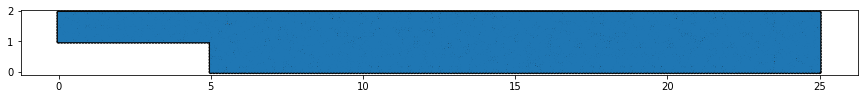

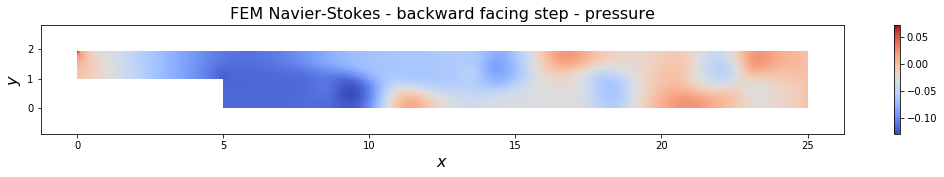

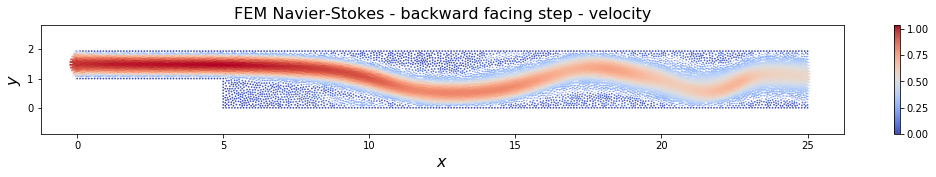

In [33]:
fig = plt.figure(figsize=(15, 2.5))
ax1 = fig.add_subplot(111)
fd.plot(mesh, axes=ax1)

fig = plt.figure(figsize=(18, 2.))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - backward facing step - pressure', fontsize=16)
fd.plot(p_now,axes=ax1)
ax1.axis('equal')

fig = plt.figure(figsize=(18, 2.))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - backward facing step - velocity', fontsize=16)
fd.plot(u_now,axes=ax1)
ax1.axis('equal')